### XGBoostを試す


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'a_mean_age':                  'int8',
 'a_std_age':                   'float16',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int32',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int32',
 'perceived_colour_value_id':   'int32',
 'perceived_colour_master_id':  'int32',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'is_for_male':                 'bool',
 'is_for_female':               'bool',
 'is_for_mama':                 'bool',
 'c_mean_price':                'float16',
 'c_std_price':                 'float16',
 'a_mean_price':                'float16',     
 'c_cv_total':                  'int32',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'a_cv_recent_on':              'int32',
 'a_cv_recent_off':             'int32',
 'a_cv_recent2':                'int32',
 'a_cv_recent_ratio':           'float16',
 'a_cv_recent_ranking':         'int16',
 'a_cv_recent_ranking2':        'int16',
 'c_mean_sales_channel_id':     'float16',
 'a_mean_sales_channel_id':     'float16',
 'c_mean_is_for_male':          'float16',
 'a_mean_is_for_male':          'float16',
 'c_mean_is_for_female':        'float16',
 'a_mean_is_for_female':        'float16',
 'c_mean_is_for_mama':          'float16',
 'diff_dat_last_buy':           'int16',
 'a_mean_is_for_mama':          'float16',
 'ca_index_group_no_num':       'int32',
 'index_group_no_similarity':   'float32',
 'ca_index_code_num':           'int32',
 'index_code_similarity':       'float32',
 'ca_product_group_no_num':     'int32',
 'product_group_no_similarity': 'float32',
 'buy_same_before':             'int16',
 'buy_same_before_recent':      'int16',
 'buy_same_last_week':          'int16',
 'buy_rank1_before':             'int16',
 'buy_rank2_before':             'int16',
 'diff_dat_last_buy_rank1':      'int16',
 'diff_dat_last_buy_rank2':      'int16',
 'delta_mean_price':            'float16',
 'delta_mean_age':              'int8',
 'delta_mean_sales_channel_id': 'float16',
 'delta_mean_is_for_male':      'float16',
 'delta_mean_is_for_female':    'float16',
 'delta_mean_is_for_mama':      'float16',
 'match_rank':                  'int8',
 'als_rank':                    'int8',
 'match_len':                   'int8'
 }

In [4]:
# train data
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09']
#train_date_list = ['2020-09-09', '2020-09-16']
train_date_list = ['2020-09-09']
#train_date_list = ['2020-09-16']
train_list = [dd.read_csv(f'./train_{date}.csv', dtype=input_type).compute() for date in train_date_list]

In [5]:
train = pd.concat([train_list[0]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
#valid = train_list[3].reset_index(drop=True)

In [6]:
# 毎回同じbaselineと比較するため固定
valid = dd.read_csv(f'./train_2020-09-16.csv', dtype=input_type).compute() 
#valid = dd.read_csv(f'./train_2020-09-09.csv', dtype=input_type).compute() 
valid = valid.reset_index(drop=True)

In [7]:
train

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-4617291842348727650,8,559616013,0,99,False,True,True,0,4,...,-0.001149,-11,0.248047,0.0,0.0,0.0,1,0,104,999
1,-4617291842348727650,8,590928001,1,99,False,True,True,0,4,...,-0.006222,-10,-0.305664,0.0,0.0,0.0,1,0,104,999
2,-4617291842348727650,8,712924012,2,99,False,True,True,0,4,...,0.006569,-10,-0.314453,0.0,0.0,0.0,0,0,999,999
3,-4617291842348727650,8,879944002,3,99,False,True,True,0,4,...,0.006569,-10,0.666992,0.0,0.0,0.0,0,1,999,104
4,-4617291842348727650,8,566140001,4,99,False,True,True,0,4,...,0.007927,-12,-0.035156,0.0,0.0,0.0,1,0,104,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880755,-2661682485847144637,0,781613006,35,99,False,True,True,0,4,...,-0.047974,-11,-1.981445,0.0,-1.0,0.0,0,0,999,999
2880756,-2661682485847144637,0,759814009,36,99,False,True,True,0,4,...,-0.032410,-10,-1.939453,0.0,-1.0,0.0,0,0,999,999
2880757,-2661682485847144637,0,850917001,37,99,False,True,True,0,4,...,-0.024429,-15,-1.780273,0.0,-1.0,0.0,0,0,999,999
2880758,-2661682485847144637,0,158340001,38,99,False,True,True,0,4,...,-0.012299,-10,-1.321289,0.0,-1.0,0.0,0,0,999,999


In [8]:
train.columns.values

array(['customer_id', 'match_len', 'article_id', 'match_rank', 'als_rank',
       'label', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'c_mean_price',
       'c_std_price', 'c_cv_total', 'c_cv_recent',
       'c_mean_sales_channel_id', 'c_mean_is_for_male',
       'c_mean_is_for_female', 'c_mean_is_for_mama', 'diff_dat_last_buy',
       'product_code', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'is_for_male',
       'is_for_female', 'is_for_mama', 'product_group_no', 'a_mean_price',
       'a_cv_total', 'a_cv_recent', 'a_cv_recent_on', 'a_cv_recent_off',
       'a_cv_recent2', 'a_cv_recent_ranking', 'a_cv_recent_ranking2',
       'a_cv_recent_ratio', 'a_mean_sales_channel_id', 'a_mean_age',
       'a_std_age', 'ca_index_group_no_num', 'index_group_no_sim

In [9]:
valid

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-216791697895142778,10,859105002,0,99,False,False,False,0,2,...,0.010979,-4,0.081055,0.111084,-0.111328,0.0,1,0,78,999
1,-216791697895142778,10,859105009,1,99,False,False,False,0,2,...,0.010094,-1,-0.043945,0.111084,-0.111328,0.0,0,0,999,999
2,-216791697895142778,10,859105004,2,99,False,False,False,0,2,...,0.011894,-2,0.066406,0.111084,-0.111328,0.0,0,0,999,999
3,-216791697895142778,10,859105006,3,99,False,False,False,0,2,...,0.010666,-4,0.146484,0.111084,-0.111328,0.0,7,0,78,999
4,-216791697895142778,10,811907011,4,99,False,False,False,0,2,...,0.006935,0,-0.258789,0.111084,-0.111328,0.0,1,0,81,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2759355,-8747047206777816159,0,841383002,35,99,False,False,False,0,2,...,-0.008110,-4,-1.806641,0.000000,-1.000000,0.0,0,0,999,999
2759356,-8747047206777816159,0,894780001,36,99,False,False,False,0,2,...,-0.033539,-3,-2.000000,0.000000,-1.000000,0.0,0,0,999,999
2759357,-8747047206777816159,0,706016001,37,99,False,False,False,0,2,...,-0.032440,0,-1.845703,0.000000,-1.000000,0.0,0,0,999,999
2759358,-8747047206777816159,0,936622001,38,99,False,False,False,0,2,...,-0.025070,-5,-2.000000,0.000000,-1.000000,0.0,0,0,999,999


In [10]:
del train_list
gc.collect()

0

## Preprocess

In [11]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,match_len,article_id,match_rank,als_rank,label,FN,Active,club_member_status,fashion_news_frequency,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-4617291842348727650,8,559616013,0,99,False,True,True,0,4,...,-0.001149,-11,0.248047,0.0,0.0,0.0,1,0,104,999
1,-4617291842348727650,8,590928001,1,99,False,True,True,0,4,...,-0.006222,-10,-0.305664,0.0,0.0,0.0,1,0,104,999
2,-4617291842348727650,8,712924012,2,99,False,True,True,0,4,...,0.006569,-10,-0.314453,0.0,0.0,0.0,0,0,999,999
3,-4617291842348727650,8,879944002,3,99,False,True,True,0,4,...,0.006569,-10,0.666992,0.0,0.0,0.0,0,1,999,104
4,-4617291842348727650,8,566140001,4,99,False,True,True,0,4,...,0.007927,-12,-0.035156,0.0,0.0,0.0,1,0,104,999


In [12]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [13]:
train_groups = train_x.groupby('customer_id').size().to_frame('size')['size'].to_numpy()
valid_groups = valid_x.groupby('customer_id').size().to_frame('size')['size'].to_numpy()
groups = (train_groups, valid_groups)

In [14]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

## Training

In [15]:
import xgboost as xgb

In [20]:
model = xgb.XGBRanker(
    #tree_method      = 'gpu_hist', # GPUを使う
    booster          = 'gbtree',
    objective        = 'rank:pairwise',
    random_state     = 0,
    learning_rate    = 0.99, # 学習率
    colsample_bytree = 0.9,
    eta              = 0.05,
    max_depth        = 7,
    n_estimators     = 500,
    subsample        = 0.75, # 0 ~ 1
    min_child_weight = 5,   # 一番重要 決定木の下限
    early_stopping_rounds=20,
)

In [21]:
#train_x = train_x['match_len']
#valid_x = valid_x['match_len']

In [22]:
valids = (valid_x, valid_y)
#model.fit(train_x, train_y, group=train_groups, eval_group=[valid_groups], eval_set=[valids], verbose='Verbose')
model.fit(train_x, train_y, group=train_groups, eval_group=[valid_groups], eval_set=[valids])

XGBRanker(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.9, early_stopping_rounds=20,
          enable_categorical=False, eta=0.05, eval_metric=None, gamma=0,
          gpu_id=-1, grow_policy='depthwise', importance_type=None,
          interaction_constraints='', learning_rate=0.99, max_bin=256,
          max_cat_to_onehot=4, max_delta_step=0, max_depth=7, max_leaves=0,
          min_child_weight=5, missing=nan, monotone_constraints='()',
          n_estimators=500, n_jobs=0, num_parallel_tree=1, predictor='auto',
          random_state=0, reg_alpha=0, ...)

In [23]:
model.feature_importances_

array([0.01201064, 0.0276228 , 0.03670259, 0.00092401, 0.        ,
       0.00471982, 0.00378523, 0.00936719, 0.00762997, 0.00814031,
       0.00884561, 0.00911982, 0.04756985, 0.00835535, 0.00701511,
       0.00808604, 0.00872485, 0.01682914, 0.0148805 , 0.00851902,
       0.01248021, 0.01132561, 0.01429375, 0.00752737, 0.01216397,
       0.01237487, 0.        , 0.00929419, 0.01027594, 0.00286395,
       0.        , 0.        , 0.01084317, 0.01144905, 0.01153045,
       0.02994564, 0.01936647, 0.03733449, 0.01001503, 0.        ,
       0.0107474 , 0.01591411, 0.01173683, 0.01008384, 0.00928958,
       0.00843889, 0.01258846, 0.00823888, 0.01690933, 0.00718898,
       0.01083986, 0.19860792, 0.10172801, 0.00902636, 0.01127555,
       0.009005  , 0.00972751, 0.00780192, 0.00851822, 0.00839768,
       0.00699511, 0.00954643, 0.01487331, 0.01058873], dtype=float32)

In [25]:
model.best_iteration

6

In [26]:
model.get_booster().feature_names

['match_len',
 'match_rank',
 'als_rank',
 'FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'c_mean_price',
 'c_std_price',
 'c_cv_total',
 'c_cv_recent',
 'c_mean_sales_channel_id',
 'c_mean_is_for_male',
 'c_mean_is_for_female',
 'c_mean_is_for_mama',
 'diff_dat_last_buy',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'is_for_male',
 'is_for_female',
 'is_for_mama',
 'product_group_no',
 'a_mean_price',
 'a_cv_total',
 'a_cv_recent',
 'a_cv_recent_on',
 'a_cv_recent_off',
 'a_cv_recent2',
 'a_cv_recent_ranking',
 'a_cv_recent_ranking2',
 'a_cv_recent_ratio',
 'a_mean_sales_channel_id',
 'a_mean_age',
 'a_std_age',
 'ca_index_group_no_num',
 'index_group_no_similarity',
 'ca_index_code_num',
 'index_code_similarity',
 'ca_product_group_no_num',
 'product_

[0.01201064 0.0276228  0.03670259 0.00092401 0.         0.00471982
 0.00378523 0.00936719 0.00762997 0.00814031 0.00884561 0.00911982
 0.04756985 0.00835535 0.00701511 0.00808604 0.00872485 0.01682914
 0.0148805  0.00851902 0.01248021 0.01132561 0.01429375 0.00752737
 0.01216397 0.01237487 0.         0.00929419 0.01027594 0.00286395
 0.         0.         0.01084317 0.01144905 0.01153045 0.02994564
 0.01936647 0.03733449 0.01001503 0.         0.0107474  0.01591411
 0.01173683 0.01008384 0.00928958 0.00843889 0.01258846 0.00823888
 0.01690933 0.00718898 0.01083986 0.19860792 0.10172801 0.00902636
 0.01127555 0.009005   0.00972751 0.00780192 0.00851822 0.00839768
 0.00699511 0.00954643 0.01487331 0.01058873]


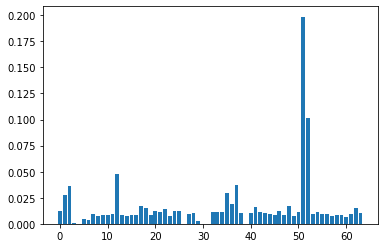

In [27]:
# plot feature importance manually
from numpy import loadtxt
from matplotlib import pyplot
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

## test

In [27]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

15638

In [28]:
# test data
#Nval = 12
#test = dd.read_csv(f'./test.csv', dtype=input_type).compute()
test = dd.read_csv(f'./test_2020-09-16.csv', dtype=input_type).compute()
test

,customer_id,match_len,article_id,match_rank,als_rank,FN,Active,club_member_status,fashion_news_frequency,age,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,-5449466430634306129,7,749699002,0,99,False,False,0,2,24,...,-0.002726,-9,-0.153320,0.0,0.0,0.0,0,0,999,999
1,-5449466430634306129,7,882899003,1,99,False,False,0,2,24,...,-0.044342,-7,-0.012695,0.0,0.0,0.0,0,0,999,999
2,-5449466430634306129,7,928905001,2,99,False,False,0,2,24,...,0.005157,-9,-0.200195,0.0,0.0,0.0,0,0,999,999
3,-5449466430634306129,7,934128001,3,99,False,False,0,2,24,...,-0.003220,-17,0.000000,0.0,0.0,0.0,0,0,999,999
4,-5449466430634306129,7,749699001,4,99,False,False,0,2,24,...,-0.002802,-9,-0.067383,0.0,0.0,0.0,1,0,7,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111310,-6680722840082728879,4,905492001,35,99,False,False,0,1,50,...,-0.034912,9,-0.400391,0.0,0.0,0.0,0,0,999,999
111311,-6680722840082728879,4,906352001,36,99,False,False,0,1,50,...,-0.033905,14,-0.203125,0.0,0.0,0.0,0,0,999,999
111312,-6680722840082728879,4,915529003,37,99,False,False,0,1,50,...,-0.009453,15,-0.204102,0.0,0.0,0.0,0,0,999,999
111313,-6680722840082728879,4,898694002,38,99,False,False,0,1,50,...,-0.026245,16,-0.400391,0.0,0.0,0.0,0,0,999,999


In [29]:
test.sort_index(inplace=True)

In [30]:
test_id = test[['customer_id', 'article_id']]
test = test.drop(['customer_id', 'article_id'], axis=1)

### prediction

In [31]:
test

,match_len,match_rank,als_rank,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama,buy_rank1_before,buy_rank2_before,diff_dat_last_buy_rank1,diff_dat_last_buy_rank2
0,7,0,99,False,False,0,2,24,162904,0.021774,...,-0.002726,-9,-0.153320,0.0,0.0,0.0,0,0,999,999
0,6,10,99,True,True,0,4,20,155849,0.017380,...,-0.024048,-15,-0.158203,0.0,0.0,0.0,0,0,999,999
0,3,9,99,False,False,0,2,23,257615,0.031052,...,-0.010422,-12,0.379883,0.0,0.0,0.0,0,0,999,999
0,3,39,99,True,True,0,4,21,349065,0.028275,...,-0.005058,-14,-0.553711,0.0,0.0,0.0,0,0,999,999
0,4,0,99,True,True,0,4,21,232092,0.041077,...,-0.008759,-12,-0.142578,0.0,0.0,0.0,0,0,999,999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111714,5,21,99,False,False,0,2,24,91478,0.038361,...,-0.011742,-10,0.003906,0.0,0.0,0.0,0,0,999,999
111715,5,22,99,False,False,0,2,24,91478,0.038361,...,0.013901,-12,0.217773,0.0,0.0,0.0,0,0,999,999
111716,5,23,99,False,False,0,2,24,91478,0.038361,...,0.015518,-8,0.263672,0.0,0.0,0.0,0,0,999,999
111717,5,24,99,False,False,0,2,24,91478,0.038361,...,-0.019577,-6,0.441406,0.0,0.0,0.0,0,0,999,999


In [32]:
test.columns.values

array(['match_len', 'match_rank', 'als_rank', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age',
       'postal_code', 'c_mean_price', 'c_std_price', 'c_cv_total',
       'c_cv_recent', 'c_mean_sales_channel_id', 'c_mean_is_for_male',
       'c_mean_is_for_female', 'c_mean_is_for_mama', 'diff_dat_last_buy',
       'product_code', 'product_type_no', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no', 'is_for_male',
       'is_for_female', 'is_for_mama', 'product_group_no', 'a_mean_price',
       'a_cv_total', 'a_cv_recent', 'a_cv_recent_on', 'a_cv_recent_off',
       'a_cv_recent2', 'a_cv_recent_ranking', 'a_cv_recent_ranking2',
       'a_cv_recent_ratio', 'a_mean_sales_channel_id', 'a_mean_age',
       'a_std_age', 'ca_index_group_no_num', 'index_group_no_similarity',
       'ca_index_code_num', 'index_

In [34]:
#pred = model.predict(test, num_iteration=200)
pred = model.predict(test, ntree_limit=model.best_ntree_limit)
pred.shape, test.shape

/home/tetsuro/.local/lib/python3.8/site-packages/xgboost/core.py:90: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


((54879200,), (54879200, 64))

In [35]:
del test, model
gc.collect()

8

In [36]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [37]:
sub1 = pd.concat([test_id, pred], axis=1)

In [38]:
#sub1 = sub1[['customer_id', 'article_id', 'score']]

In [39]:
sub1

,customer_id,article_id,score
0,-5449466430634306129,749699002,1.968532
1,6211733102869751205,918522001,0.864528
2,-398316065214153929,924243001,1.283093
3,8541635545749385918,915529003,0.835606
4,-4236472338739829826,912579002,2.966668
...,...,...,...
54879195,1254218249113875981,896169005,0.463794
54879196,1254218249113875981,850917001,0.384302
54879197,1254218249113875981,761406001,-0.170969
54879198,1254218249113875981,926502001,0.468906


In [44]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [45]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [46]:
sub1['prediction'].apply(len)

0          40
1          40
2          40
3          40
4          40
           ..
1371975    40
1371976    40
1371977    40
1371978    40
1371979    40
Name: prediction, Length: 1371980, dtype: int64

In [47]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0          12
1          12
2          12
3          12
4          12
           ..
1371975    12
1371976    12
1371977    12
1371978    12
1371979    12
Name: prediction, Length: 1371980, dtype: int64

In [48]:
sub1['prediction']

0          [706016001, 673396002, 812167004, 706016002, 9...
1          [910601003, 908292002, 903926002, 910601003, 8...
2          [924243001, 918522001, 896152002, 915529003, 8...
3          [918522001, 924243001, 448509014, 918292001, 8...
4          [918522001, 762846027, 896152002, 910601003, 7...
                                 ...                        
1371975    [918525001, 448509014, 924243001, 929165002, 7...
1371976    [658030011, 918292001, 706016001, 871710001, 7...
1371977    [448509014, 918525001, 924243001, 929165002, 9...
1371978    [918522001, 896152002, 863646001, 762846027, 6...
1371979    [781758003, 924243001, 918525001, 781758001, 9...
Name: prediction, Length: 1371980, dtype: object

In [49]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [50]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0673396002 0812167004 0706016002 09...
1,-9223343869995384291,0910601003 0908292002 0903926002 0910601003 08...
2,-9223321797620987725,0924243001 0918522001 0896152002 0915529003 08...
3,-9223319430705797669,0918522001 0924243001 0448509014 0918292001 08...
4,-9223308614576639426,0918522001 0762846027 0896152002 0910601003 07...
...,...,...
1371975,9223319300843860958,0918525001 0448509014 0924243001 0929165002 07...
1371976,9223333063893176977,0658030011 0918292001 0706016001 0871710001 07...
1371977,9223345314868180224,0448509014 0918525001 0924243001 0929165002 09...
1371978,9223357421094039679,0918522001 0896152002 0863646001 0762846027 06...


## Submit

In [51]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [52]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [53]:
print(sub.shape, sub1.shape)

(1371980, 2) (1371980, 2)


In [54]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [55]:
sub1

,customer_id,prediction
0,-9223352921020755230,0706016001 0673396002 0812167004 0706016002 09...
1,-9223343869995384291,0910601003 0908292002 0903926002 0910601003 08...
2,-9223321797620987725,0924243001 0918522001 0896152002 0915529003 08...
3,-9223319430705797669,0918522001 0924243001 0448509014 0918292001 08...
4,-9223308614576639426,0918522001 0762846027 0896152002 0910601003 07...
...,...,...
1371975,9223319300843860958,0918525001 0448509014 0924243001 0929165002 07...
1371976,9223333063893176977,0658030011 0918292001 0706016001 0871710001 07...
1371977,9223345314868180224,0448509014 0918525001 0924243001 0929165002 09...
1371978,9223357421094039679,0918522001 0896152002 0863646001 0762846027 06...


In [56]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [57]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [58]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0568601043 0918525001 0924243001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0918522001 0924243001 0706016002 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0805000001 0926502001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0918522001 0924243001 0873274002 0893059005 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0730683050 0896152002 0918522001 09...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0611415001 0720125039 0918292001 07...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0448509014 0762846031 0762846008 0706016002 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846031 0706016002 0689365050 0762846006 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0448509014 0918292001 0918522001 0464297007 07...


In [59]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission_xgb.csv', index=False)

(1371980, 2)
